In [1]:
%env TF_CPP_MIN_LOG_LEVEL=3

env: TF_CPP_MIN_LOG_LEVEL=3


In [ ]:
!python3 -m pip install -q tensorflow
!python3 -m pip install -q yfinance # https://pypi.org/project/yfinance/
!python3 -m pip install -q ta # https://pypi.org/project/ta/

In [2]:
import ta
import sklearn
import pandas as pd
import numpy as np
import tensorflow
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

In [8]:
def download_data(ticker: str, start: str = "2022-01-01", end: str = "2023-12-31"):

    df = yf.download(ticker, start=start, end=end)

    df.columns = ["adj_close", "close", "high", "low", "open", "volume"] # https://ranaroussi.github.io/yfinance/reference/api/yfinance.download.html#yfinance.download
    df.index.name = "date"

    return df

In [12]:
df = download_data("MSFT")

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['MSFT']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


In [10]:
df.columns

Index(['adj_close', 'close', 'high', 'low', 'open', 'volume'], dtype='object')

In [11]:
df.head()

,adj_close,close,high,low,open,volume
date,,,,,,


In [8]:
df.tail()

,close,high,low,open,volume
date,,,,,
2023-12-22,371.799713,372.395266,369.943598,370.906399,17091100
2023-12-26,371.879120,374.142196,370.727726,372.216593,12673100
2023-12-27,371.293518,372.276160,370.042861,370.916334,14905400
2023-12-28,372.494507,373.665741,371.382825,372.583835,14327000
2023-12-29,373.248871,374.360553,370.707875,373.209159,18723000


In [9]:
# Feature Engineering
def feature_engineering(df, window=5):

    # Cópia do dataframe
    result_df = df.copy()

    result_df["close_pct_change"] = result_df["close"].pct_change(1) # target

    result_df["op"] = result_df["open"].shift(1)
    result_df["hi"] = result_df["high"].shift(1)
    result_df["lo"] = result_df["low"].shift(1)
    result_df["clo"] = result_df["close"].shift(1)

    result_df["vol"] = result_df["volume"].shift(1)

    # Simple Moving Average (SMA)
    result_df["sma_15"] = result_df[["close"]].rolling(15).mean().shift(1)
    result_df["sma_60"] = result_df[["close"]].rolling(60).mean().shift(1)

    # Moving Standard Deviation (MSD) - Volatilidade
    result_df["msd_15"] = result_df["close_pct_change"].rolling(15).std().shift(1)
    result_df["msd_60"] = result_df["close_pct_change"].rolling(60).std().shift(1)

    # Volume Weighted Average Price (VWAP)
    vwap = ta.volume.VolumeWeightedAveragePrice(high=df['high'],
                                                low=df['low'],
                                                close=df['close'],
                                                volume=df['volume'],
                                                window=window)
    result_df["vwap"] = vwap.vwap.shift(1)

    # Relative Strength Index (RSI)
    RSI = ta.momentum.RSIIndicator(result_df["close"], window=window, fillna=False)
    result_df["rsi"] = RSI.rsi().shift(1)

    return result_df.dropna().drop(["open", "high", "low", "close", "volume"], axis=1).sort_index()

In [10]:
features_target_df = feature_engineering(df)

In [11]:
features_target_df.head()

,close_pct_change,op,hi,lo,clo,vol,sma_15,sma_60,msd_15,msd_60,vwap,rsi
date,,,,,,,,,,,,
2022-03-31,-0.017683,306.460700,308.599754,304.331393,306.558350,28163600.0,291.051060,292.873312,0.017195,0.020944,301.467382,75.353796
2022-04-01,0.003601,306.597370,307.808543,300.727208,301.137421,33422100.0,292.530487,292.547389,0.017797,0.020951,302.943619,55.617561
2022-04-04,0.017937,302.172856,302.915185,298.431969,302.221710,27110500.0,294.441636,292.444716,0.016469,0.020369,303.711375,58.345311
2022-04-05,-0.012985,302.876071,307.779275,302.504907,307.642548,24289600.0,296.950545,292.473004,0.015738,0.020474,304.565485,69.904477
2022-04-06,-0.036606,305.982089,307.544872,302.661192,303.647705,23156700.0,298.495742,292.432111,0.014324,0.020546,304.223972,55.672986


In [12]:
# Data Pre-processing

pct_train = 0.7
pct_val   = 0.2
# pct_test  = 0.1

split_train = int(pct_train*len(features_target_df))
split_val   = int(pct_val*len(features_target_df))
# split_test  = int(pct_test*len(features_target_df))

split_train + split_val, len(features_target_df)

(396, 440)

In [ ]:
train_df = features_target_df.iloc[:split_train, :] # interval [0, split_train)
X_train = train_df.drop("close_pct_change", axis=1)
y_train = train_df.close_pct_change.values

val_df = features_target_df.iloc[split_train:split_train+split_val, :] # interval [split_train, split_train+split_val)
X_val = val_df.drop("close_pct_change", axis=1)
y_val = val_df.close_pct_change.values

test_df = features_target_df.iloc[split_train+split_val:, :] # interval [split_train+split_val, end]
X_test = test_df.drop("close_pct_change", axis=1)
y_test = test_df.close_pct_change.values

In [14]:
train_df.shape[0], val_df.shape[0], test_df.shape[0], train_df.shape[0] + val_df.shape[0] + test_df.shape[0]

(308, 88, 44, 440)

In [15]:
# Scaling
sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)
X_val_scaled   = sc.transform(X_val)
X_test_scaled  = sc.transform(X_test)

In [16]:
X_train

,op,hi,lo,clo,vol,sma_15,sma_60,msd_15,msd_60,vwap,rsi
date,,,,,,,,,,,
2022-03-31,306.460700,308.599754,304.331393,306.558350,28163600.0,291.051060,292.873312,0.017195,0.020944,301.467382,75.353796
2022-04-01,306.597370,307.808543,300.727208,301.137421,33422100.0,292.530487,292.547389,0.017797,0.020951,302.943619,55.617561
2022-04-04,302.172856,302.915185,298.431969,302.221710,27110500.0,294.441636,292.444716,0.016469,0.020369,303.711375,58.345311
2022-04-05,302.876071,307.779275,302.504907,307.642548,24289600.0,296.950545,292.473004,0.015738,0.020474,304.565485,69.904477
2022-04-06,305.982089,307.544872,302.661192,303.647705,23156700.0,298.495742,292.432111,0.014324,0.020546,304.223972,55.672986
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-15,330.486482,335.132323,328.974117,333.451904,26003800.0,326.115466,299.889669,0.015585,0.016044,326.759476,72.346888
2023-06-16,333.590299,345.807826,333.313527,344.087891,38899100.0,328.372481,301.123898,0.016844,0.016450,331.831846,84.517662
2023-06-20,347.270804,347.419069,338.008805,338.384399,46533600.0,329.453870,302.287563,0.015453,0.016622,335.812114,65.263741


In [17]:
X_train_scaled

array([[ 1.57871938,  1.54646433,  1.61236106, ..., -0.15943833,
         1.44499673,  1.2281965 ],
       [ 1.58363964,  1.51789457,  1.48267711, ..., -0.15681364,
         1.49958456,  0.20027421],
       [ 1.42435342,  1.3412008 ,  1.40009097, ..., -0.36931257,
         1.52797437,  0.34234364],
       ...,
       [ 3.04791713,  2.94818687,  2.8241248 , ..., -1.73599885,
         2.71498538,  0.70267622],
       [ 2.62053075,  2.61303238,  2.60752272, ..., -1.73462629,
         2.76389579,  0.10989991],
       [ 2.5159084 ,  2.45777022,  2.47272565, ..., -1.6936008 ,
         2.7635998 , -0.41242181]])

In [18]:
y_train.shape[0]

308

In [20]:
X_lst = []
variable = 0 # first column
lag = 5
X = []
for i in range(lag, X_test_scaled.shape[0]):
    print(i-lag, i)
    X_sliced = X_test_scaled[i-lag:i, variable]
    X.append(X_sliced)

X_lst.append(X)

0 5
1 6
2 7
3 8
4 9
5 10
6 11
7 12
8 13
9 14
10 15
11 16
12 17
13 18
14 19
15 20
16 21
17 22
18 23
19 24
20 25
21 26
22 27
23 28
24 29
25 30
26 31
27 32
28 33
29 34
30 35
31 36
32 37
33 38
34 39
35 40
36 41
37 42
38 43


In [25]:
np.array(X_lst).shape

(1, 39, 5)

In [21]:
y_test

array([ 5.85551883e-03,  2.27402931e-02,  2.37178583e-03,  2.35426454e-02,
        6.50152723e-03,  1.28616581e-02,  1.05726761e-02,  1.12192855e-02,
        7.40574013e-03, -6.91089054e-03,  2.48968170e-02, -8.08836809e-03,
        9.79051473e-03,  4.05955557e-04,  1.75834096e-02, -1.68009429e-02,
        2.05217398e-02, -1.15779747e-02,  1.28126530e-02, -1.11168161e-03,
        3.12638789e-03,  1.08028069e-02, -1.00601459e-02,  1.58415662e-04,
       -1.16123332e-02, -1.43385654e-02,  9.15626926e-03, -9.98602524e-03,
        5.82969436e-03,  8.84222120e-03, -7.82952328e-03,  8.29531789e-03,
       -2.68547231e-05, -2.25444474e-02,  1.31172662e-02,  5.17883982e-03,
        1.63716273e-03, -7.07294656e-03,  7.87874238e-03,  2.78410919e-03,
        2.13573963e-04, -1.57471010e-03,  3.23460742e-03,  2.02516816e-03])

In [28]:
i = 0
y_test[i].reshape(-1,1).transpose()

array([[0.00585552]])

In [29]:
y_lst = []
for i in range(lag, y_test.shape[0]):
    y_lst.append(y_test[i].reshape(-1,1).transpose())

In [32]:
y_lst = np.concatenate(y_lst, axis=0)

In [33]:
np.array(y_lst)

array([[ 1.28616581e-02],
       [ 1.05726761e-02],
       [ 1.12192855e-02],
       [ 7.40574013e-03],
       [-6.91089054e-03],
       [ 2.48968170e-02],
       [-8.08836809e-03],
       [ 9.79051473e-03],
       [ 4.05955557e-04],
       [ 1.75834096e-02],
       [-1.68009429e-02],
       [ 2.05217398e-02],
       [-1.15779747e-02],
       [ 1.28126530e-02],
       [-1.11168161e-03],
       [ 3.12638789e-03],
       [ 1.08028069e-02],
       [-1.00601459e-02],
       [ 1.58415662e-04],
       [-1.16123332e-02],
       [-1.43385654e-02],
       [ 9.15626926e-03],
       [-9.98602524e-03],
       [ 5.82969436e-03],
       [ 8.84222120e-03],
       [-7.82952328e-03],
       [ 8.29531789e-03],
       [-2.68547231e-05],
       [-2.25444474e-02],
       [ 1.31172662e-02],
       [ 5.17883982e-03],
       [ 1.63716273e-03],
       [-7.07294656e-03],
       [ 7.87874238e-03],
       [ 2.78410919e-03],
       [ 2.13573963e-04],
       [-1.57471010e-03],
       [ 3.23460742e-03],
       [ 2.0

In [34]:
np.array(y_lst).shape

(39, 1)

In [35]:
def format_data(X_s, y_s, lag):

    if len(X_s) != len(y_s):
        print("Warning: samples with different size!")

    X_train = []
    for variable in range(0, X_s.shape[1]):
        X = []
        
        for i in range(lag, X_s.shape[0]):
            X.append(X_s[i-lag:i, variable])
        
        X_train.append(X)
    
    X_train, np.array(X_train)
    X_train = np.swapaxes(np.swapaxes(X_train, 0, 1), 1, 2)

    y_train = []
    for i in range(lag, y_s.shape[0]):
        y_train.append(y_s[i].reshape(-1,1).transpose())
    
    y_train = np.concatenate(y_train, axis=0)
    
    return X_train, y_train

In [36]:
lag = 5

X_train2, y_train2 = format_data(X_train_scaled, y_train, lag=lag)
X_val2, y_val2     = format_data(X_val_scaled, y_val, lag=lag)
X_test2, y_test2   = format_data(X_test_scaled, y_test, lag=lag)

In [39]:
X_train_scaled.shape

(308, 11)

In [40]:
X_train2.shape

(303, 5, 11)

In [41]:
y_train2.shape

(303, 1)

In [42]:
X_train2[0]

array([[ 1.57871938,  1.54646433,  1.61236106,  1.5754579 , -0.13531235,
         1.16320701,  1.74623519, -0.62788834, -0.15943833,  1.44499673,
         1.2281965 ],
       [ 1.58363964,  1.51789457,  1.48267711,  1.38057402,  0.39032454,
         1.22225091,  1.72878194, -0.51731361, -0.15681364,  1.49958456,
         0.20027421],
       [ 1.42435342,  1.3412008 ,  1.40009097,  1.41955453, -0.24057967,
         1.29852482,  1.72328379, -0.76134411, -0.36931257,  1.52797437,
         0.34234364],
       [ 1.44966976,  1.51683774,  1.54664136,  1.61443512, -0.52255535,
         1.39865532,  1.72479861, -0.8956818 , -0.33071016,  1.55955739,
         0.94437964],
       [ 1.56148898,  1.50837371,  1.55226475,  1.47081944, -0.63579943,
         1.46032408,  1.72260878, -1.1554968 , -0.30457973,  1.54692905,
         0.20316092]])

In [46]:
y_train2[0]

array([0.00624378])

In [47]:
for i in range(5):
    print(X_train_scaled[i], y_test[i])

[ 1.57871938  1.54646433  1.61236106  1.5754579  -0.13531235  1.16320701
  1.74623519 -0.62788834 -0.15943833  1.44499673  1.2281965 ] 0.0058555188311963935
[ 1.58363964  1.51789457  1.48267711  1.38057402  0.39032454  1.22225091
  1.72878194 -0.51731361 -0.15681364  1.49958456  0.20027421] 0.022740293076186413
[ 1.42435342  1.3412008   1.40009097  1.41955453 -0.24057967  1.29852482
  1.72328379 -0.76134411 -0.36931257  1.52797437  0.34234364] 0.002371785831977391
[ 1.44966976  1.51683774  1.54664136  1.61443512 -0.52255535  1.39865532
  1.72479861 -0.8956818  -0.33071016  1.55955739  0.94437964] 0.023542645434764475
[ 1.56148898  1.50837371  1.55226475  1.47081944 -0.63579943  1.46032408
  1.72260878 -1.1554968  -0.30457973  1.54692905  0.20316092] 0.006501527233958582


In [48]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):    

    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x, x)
    x = layers.Dropout(dropout)(x)
    
    res = x + inputs
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    
    return x + res

In [49]:
def create_model(
        input_shape, 
        head_size, 
        num_heads, 
        ff_dim, 
        num_transformer_blocks, 
        mlp_units, 
        dropout=0, 
        mlp_dropout=0):
    
    inputs = tensorflow.keras.Input(shape=input_shape)
    
    x = inputs
    x = layers.LSTM(10, return_sequences=True)(x)
    
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    x = layers.GRU(100, return_sequences=False)(x)
    x = layers.Dropout(mlp_dropout)(x)
    x = layers.Dense(mlp_units, activation="relu")(x)
    
    outputs = layers.Dense(1)(x)
    
    return tensorflow.keras.Model(inputs, outputs)

In [50]:
input_shape = X_train2.shape[1:]
input_shape

(5, 11)

In [51]:
model = create_model(
    input_shape=input_shape, 
    head_size=16, 
    num_heads=1, 
    ff_dim=4, 
    num_transformer_blocks=1, 
    mlp_units=125, 
    dropout=0.1, 
    mlp_dropout=0.25
)

In [52]:
model.compile(loss="mean_squared_error", optimizer=tensorflow.keras.optimizers.Adam())

In [53]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 5, 11)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 5, 10)                880       ['input_1[0][0]']             
                                                                                                  
 layer_normalization (Layer  (None, 5, 10)                20        ['lstm[0][0]']                
 Normalization)                                                                                   
                                                                                                  
 multi_head_attention (Mult  (None, 5, 10)                698       ['layer_normalization[0][0

In [54]:
callbacks = [tensorflow.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]

In [55]:
%%time

model.fit(
    X_train2, y_train2, 
    validation_data=(X_val2, y_val2), 
    epochs=20, 
    batch_size=64, 
    callbacks=callbacks
)

Epoch 1/20
5/5 [==============================] - 5s 224ms/step - loss: 0.0175 - val_loss: 0.0024
Epoch 2/20
5/5 [==============================] - 0s 31ms/step - loss: 0.0092 - val_loss: 0.0047
Epoch 3/20
5/5 [==============================] - 0s 55ms/step - loss: 0.0052 - val_loss: 5.2972e-04
Epoch 4/20
5/5 [==============================] - 0s 36ms/step - loss: 0.0030 - val_loss: 7.1393e-04
Epoch 5/20
5/5 [==============================] - 0s 53ms/step - loss: 0.0023 - val_loss: 6.6546e-04
Epoch 6/20
5/5 [==============================] - 0s 51ms/step - loss: 0.0020 - val_loss: 3.4446e-04
Epoch 7/20
5/5 [==============================] - 0s 52ms/step - loss: 0.0018 - val_loss: 4.6180e-04
Epoch 8/20
5/5 [==============================] - 0s 49ms/step - loss: 0.0016 - val_loss: 3.6529e-04
Epoch 9/20
5/5 [==============================] - 0s 52ms/step - loss: 0.0015 - val_loss: 3.3097e-04
Epoch 10/20
5/5 [==============================] - 0s 46ms/step - loss: 0.0014 - val_loss: 3.3733e

<Axes: >

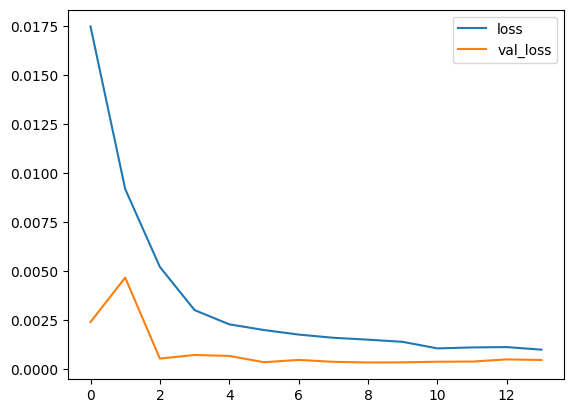

In [56]:
pd.DataFrame(model.history.history).plot()

In [57]:
pred = model.predict(X_test2)

2/2 [==============================] - 1s 9ms/step


In [59]:
score = np.sqrt(metrics.mean_squared_error(pred, y_test2))
score

0.015354580843516727